# Characterize Mercer, Novel, All BPs

For each group plot:
- Phastcons
- PhyloP
- Distance from 3'ss
- PWM

both seperately and all on one plot.

In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [4]:
# file is result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [6]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y, chroms, coords, strands = [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2]).reshape(1, L, 6)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords), np.array(strands))

(X_known, y_known,
 k_chroms, k_coords, k_strands) = encode(known, phastcons, phylop)
(X_novel, y_novel, 
 n_chroms, n_coords, n_strands) = encode(missing, phastcons, phylop)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 56808.0
(169182, 70, 6) (37110, 70, 6)


In [7]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [8]:
y_novel = model.predict(X_novel[:, :, :4]).reshape(-1, L)
p_known = model.predict(X_known[:, :, :4]).reshape(-1, L)

X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])

In [9]:
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])

# BPs per 3'ss

In [10]:
_y_known = np.zeros(y_known.shape)
_y_known[y_known == 1] = 1
for i, (seq, t) in enumerate(zip(X_known, y_known)):
    if np.sum(seq[t != 0, 0]):
        _y_known[i] = seq[:, 0] * t

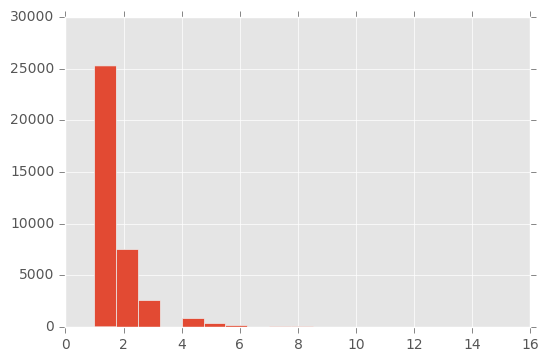

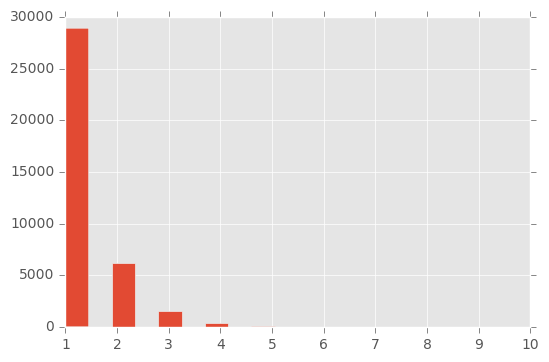

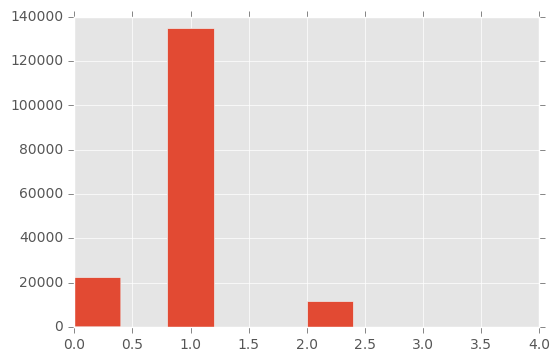

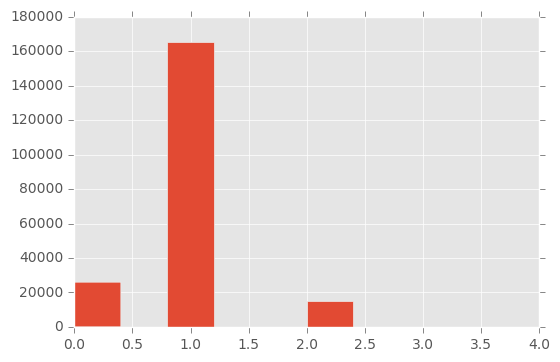

In [11]:
plt.hist(np.sum(y_known, axis = 1), bins = 20)
plt.show()
plt.hist(np.sum(_y_known, axis = 1), bins = 20)
plt.show()
plt.hist(np.sum(y_novel > .5, axis = 1))
plt.show()
plt.hist(np.sum(y_all > .5, axis = 1))
plt.show()

## Conservation Meta

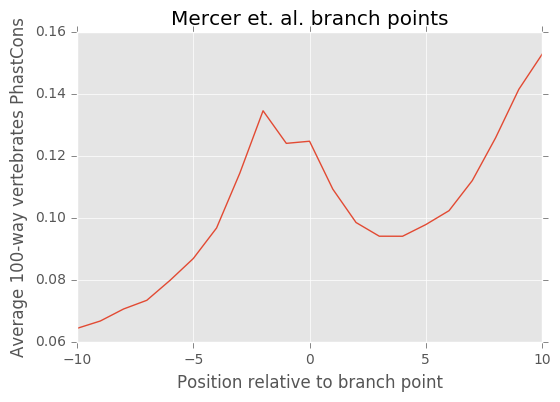

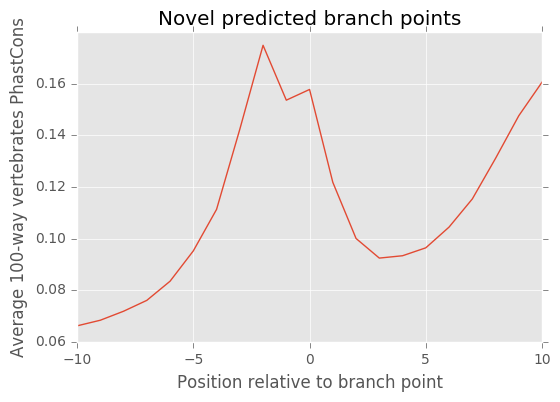

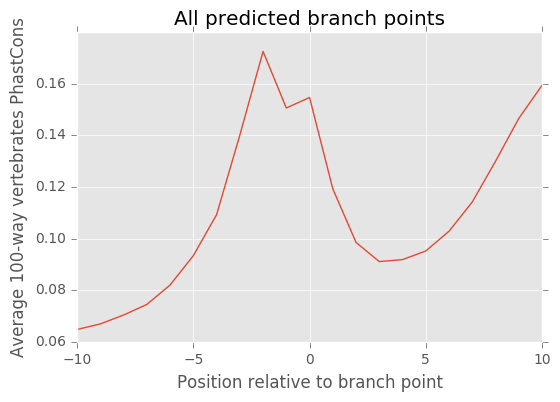

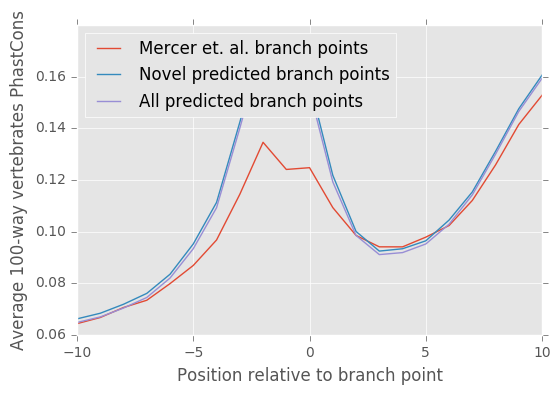

In [12]:
K = 10

def cons_known(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts = counts + seq[bp-K: bp+K+1, idx]
            total += 1
    return counts / total

def cons_novel(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, idx]
        total += 1
    return counts / total

def cons_second(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp1 = np.argmax(target)
        bp2 = np.argmax(np.hstack([target[:bp1],
                                   np.zeros((1,)),
                                   target[bp1+1:]]))
        if 0 > bp2-K or bp2+K+1 > seq.shape[0]: continue
        if bp2 < thresh: continue
        counts = counts + seq[bp-K: bp+K+1, idx]
        total += 1
    return counts / total

known = cons_known(X_known, y_known, 4)
novel = cons_novel(X_novel, y_novel, 4)
allbp = cons_novel(X_all,   y_all,   4)

names = ['Mercer et. al. branch points',
         'Novel predicted branch points',
         'All predicted branch points']
cons = [known, novel, allbp]

for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
plt.legend(loc = 'best')
plt.show()

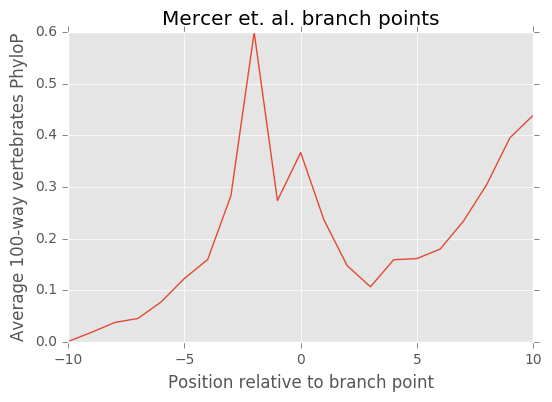

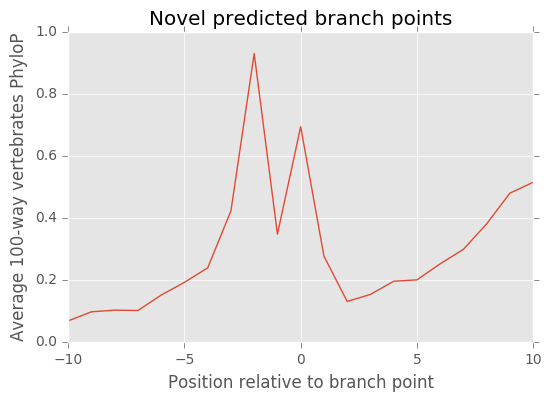

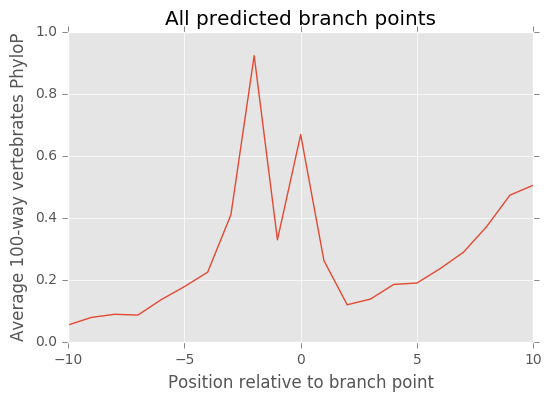

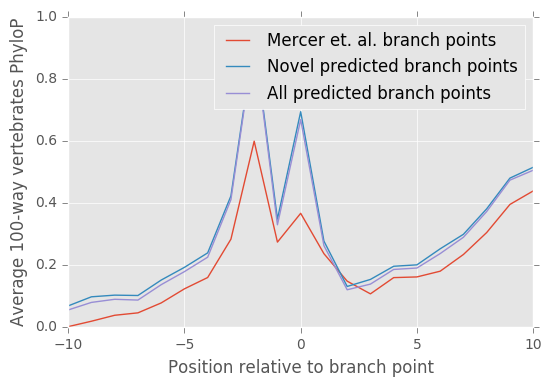

In [13]:
known = cons_known(X_known, y_known, 5)
novel = cons_novel(X_novel, y_novel, 5)
allbp = cons_novel(X_all,   y_all,   5)

names = ['Mercer et. al. branch points',
         'Novel predicted branch points',
         'All predicted branch points']
cons = [known, novel, allbp]

for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
plt.legend(loc = 'best')
plt.show()

In [2]:
# By BP nucleotide
K = 10
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1), cons_known(X_known, y_known * X_known[:, :, i], 4), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
plt.legend(loc = 'best')
plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1), cons_known(X_known, y_known * X_known[:, :, i], 5), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
plt.legend(loc = 'best')
plt.show()

NameError: name 'bases' is not defined

In [1]:
# By BP nucleotide
K = 10
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1), cons_novel(X_all, y_all * X_all[:, :, i], 4), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1), cons_novel(X_all, y_all * X_all[:, :, i], 5), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()

NameError: name 'bases' is not defined

In [ ]:
K = 10
def cons_second(X, y, idx, thresh):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp1 = np.argmax(target)
        bp2 = np.argmax(np.hstack([target[:bp1],
                                   np.zeros((1,)),
                                   target[bp1+1:]]))
        if abs(bp1-bp2) < 5: continue
        if target[bp2] < thresh: continue
        if 0 > bp2-K or bp2+K+1 > seq.shape[0]: continue
        
        counts += seq[bp2-K: bp2+K+1, idx]
        total += 1
    print thresh, total
    return counts / total

for thresh in np.linspace(0, 1, 11):
    plt.plot(range(-K, K+1),
             cons_second(X_all, y_all*X_all[:, :, 0], 4, thresh), label = str(thresh))
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')

plt.show()
for thresh in np.linspace(0, 1, 11):
    plt.plot(range(-K, K+1),
             cons_second(X_all, y_all*X_all[:, :, 0], 5, thresh), label = str(thresh))
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
plt.show()

## Dists

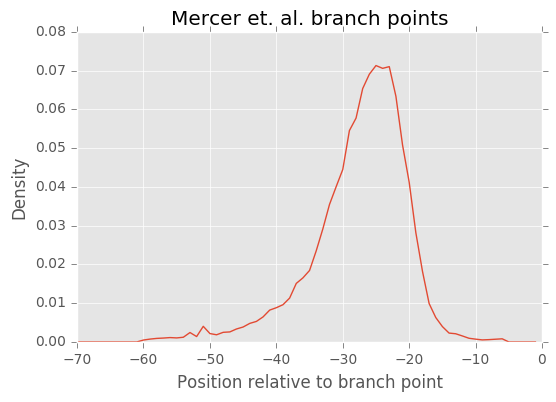

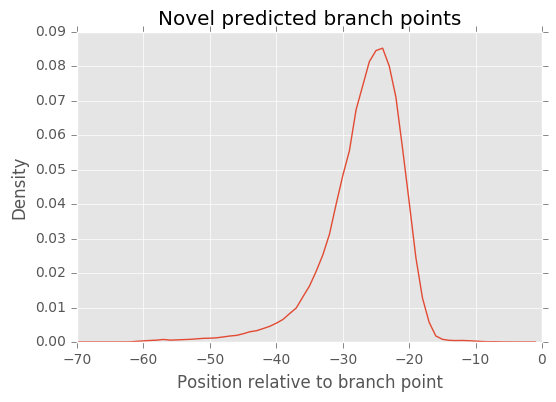

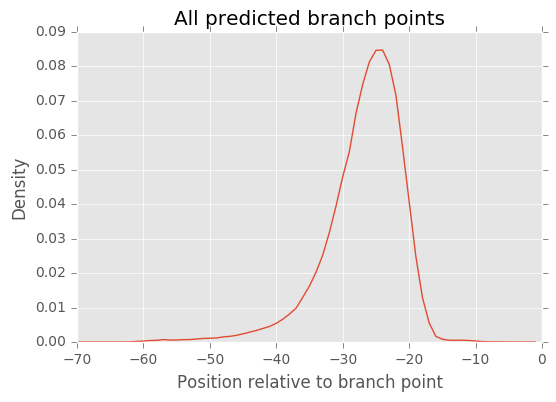

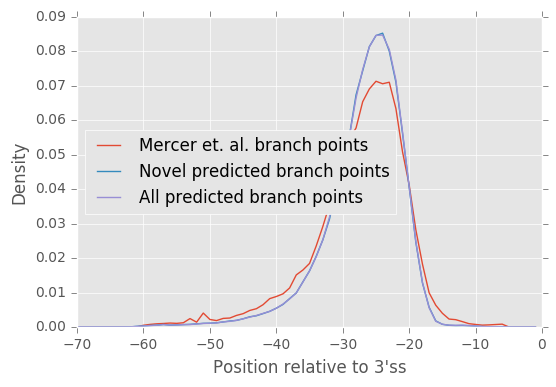

In [15]:
def dist_known(X, y, idx):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            counts[bp] += 1
            total += 1
    return counts / total

def dist_novel(X, y, idx):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.array(range(L))[target > .5]:
            counts[bp] += 1
            total += 1
    return counts / total

known = dist_known(X_known, y_known, 4)
novel = dist_novel(X_novel, y_novel, 4)
allbp = dist_novel(X_all,   y_all,   4)

dists = [known, novel, allbp]

for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Density')
    plt.show()
    
for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist, label = name)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

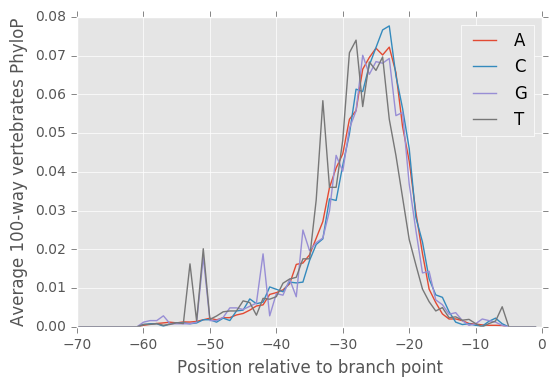

In [16]:
for i, base in enumerate(bases):
    plt.plot(range(-L, 0), dist_known(X_known, y_known * X_known[:, :, i], 5), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
plt.legend(loc = 'best')
plt.show()

## PWM

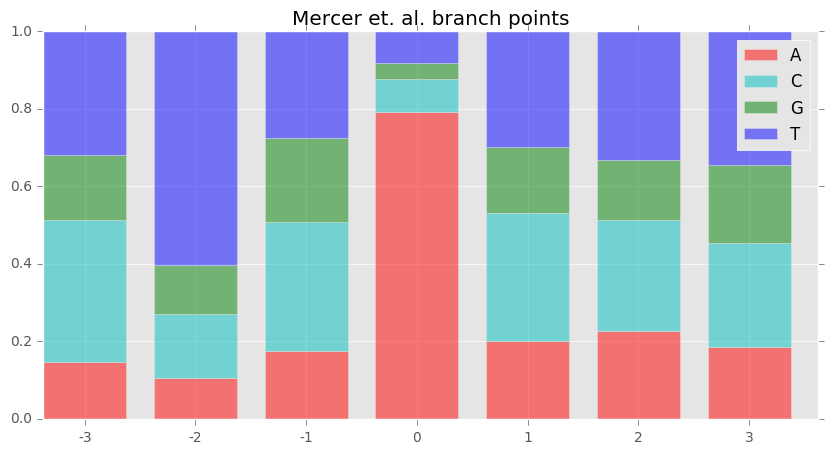

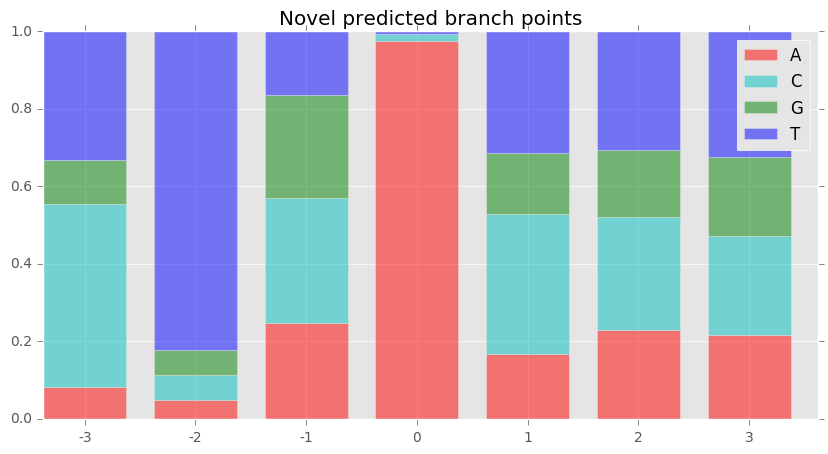

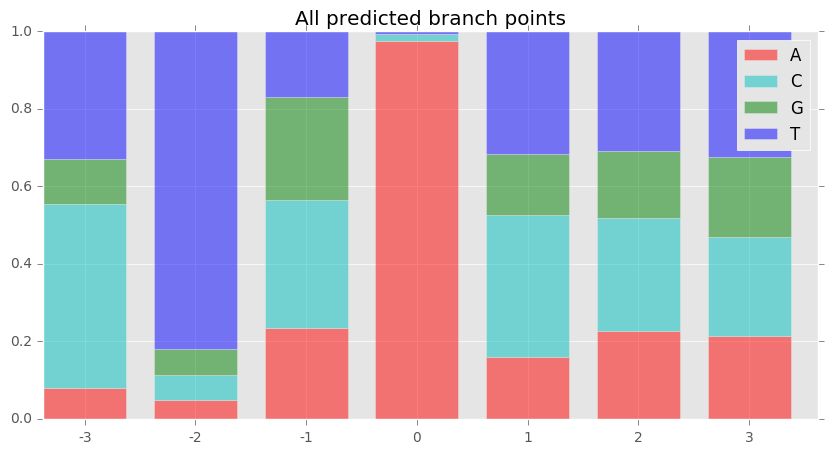

In [17]:
def pwm_logo(pwm, title):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

# Known
K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm_logo(counts / total, names[0])

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_novel, X_novel):
    for bp in np.array(range(L))[target > .5]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm_logo(counts / total, names[1])

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    for bp in np.array(range(L))[target > .5]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm_logo(counts / total, names[2])

44922


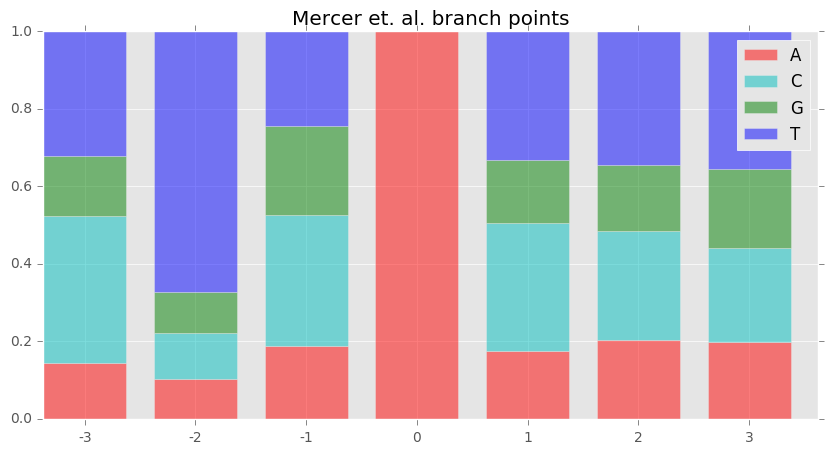

4840


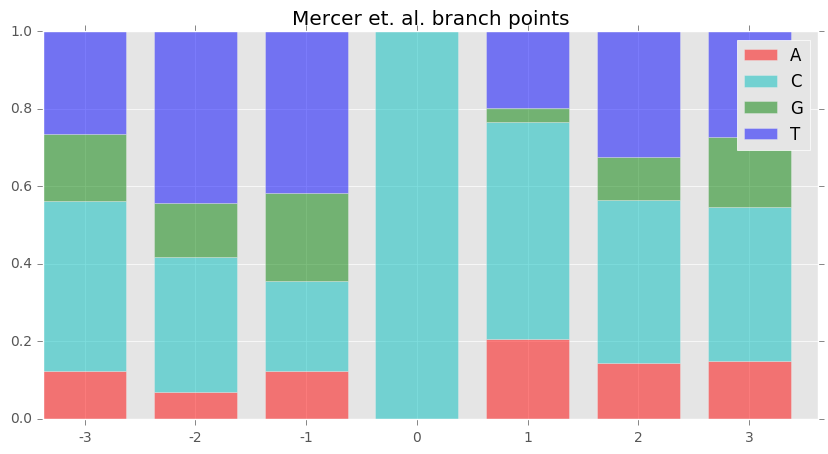

2439


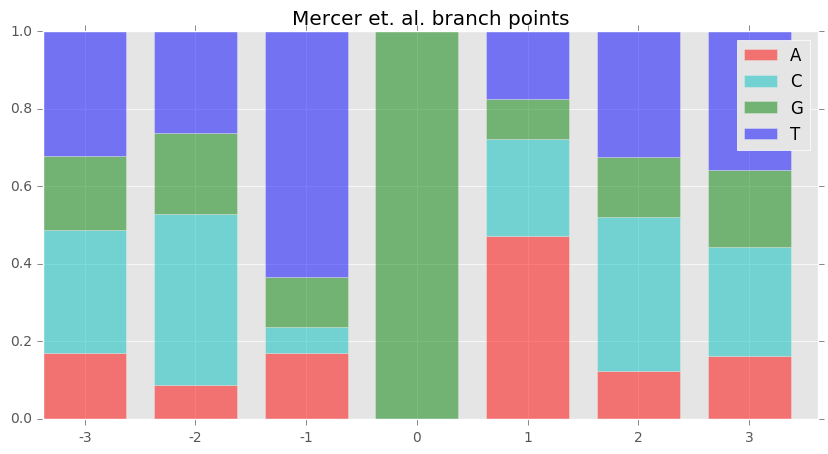

4607


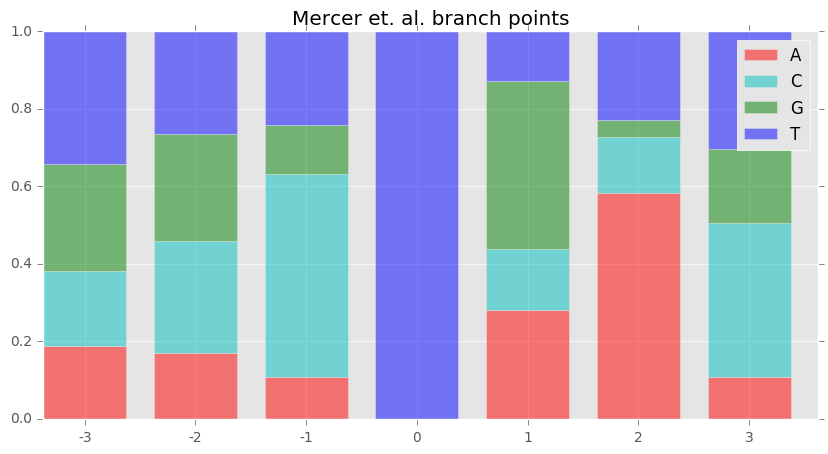

In [18]:
for i, base in enumerate(bases):
    
    K = 3
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_known* X_known[:, :, i], X_known):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts = counts + seq[bp-K: bp+K+1, :4]
            total += 1
    print total
    pwm_logo(counts / total, names[0])

202799


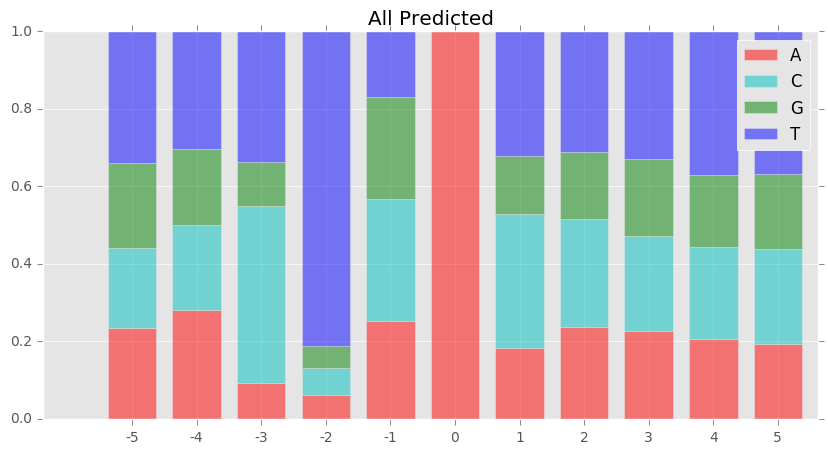

3351


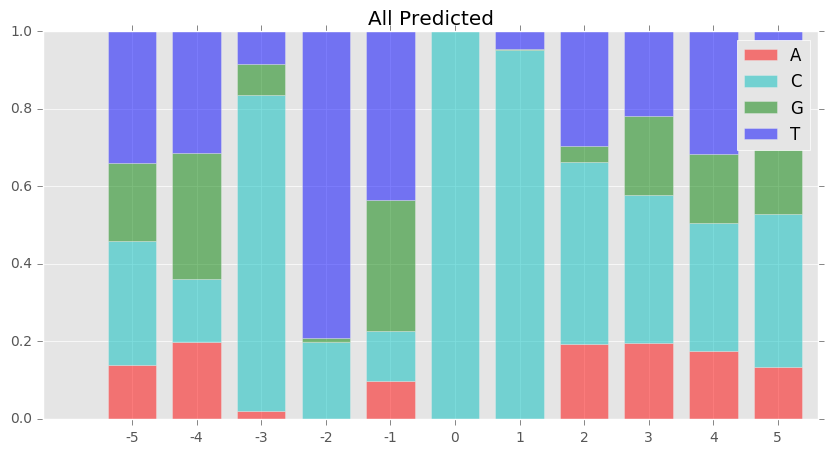

57


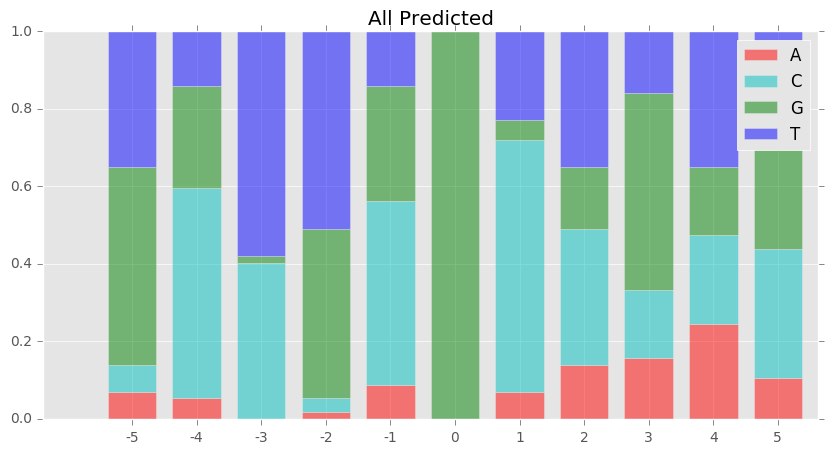

69


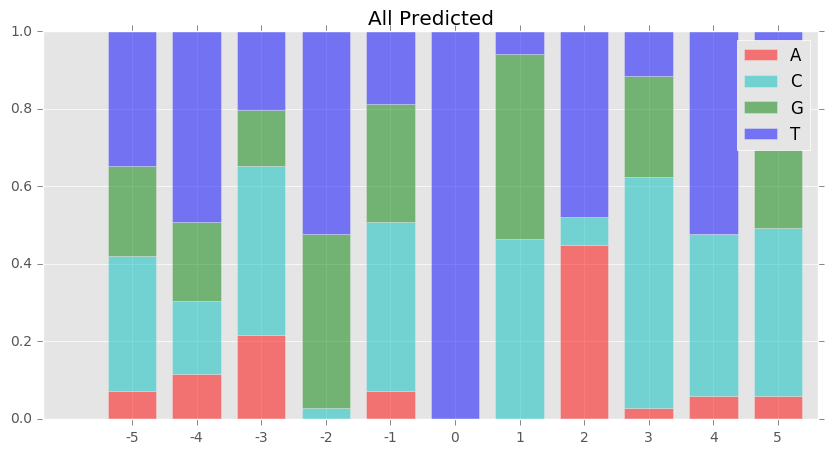

In [61]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_all, X_all):
        bp = np.argmax(target)
        if not seq[bp, i]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
    print total
    pwm_logo(counts / total, 'All Predicted')

76726


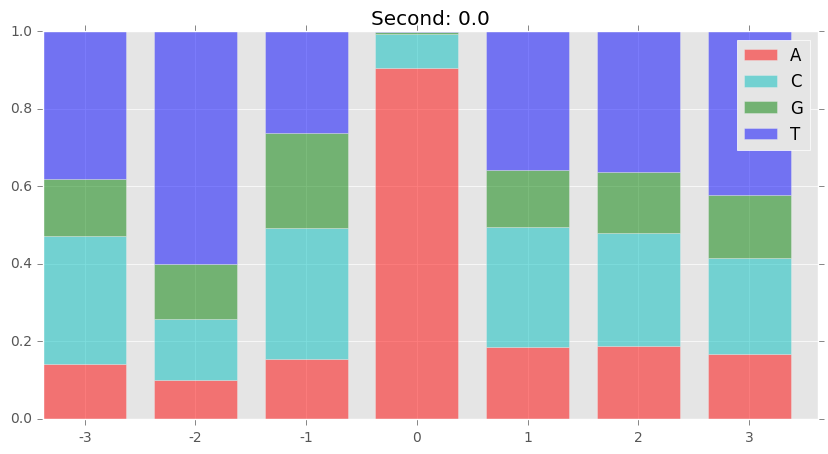

71765


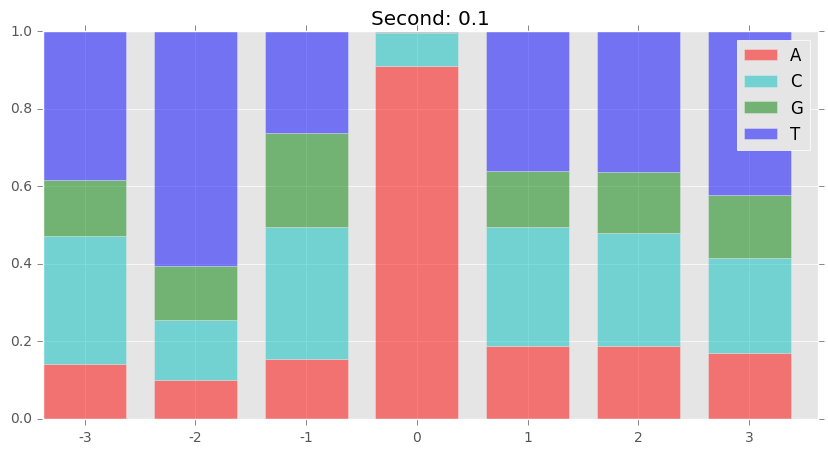

57300


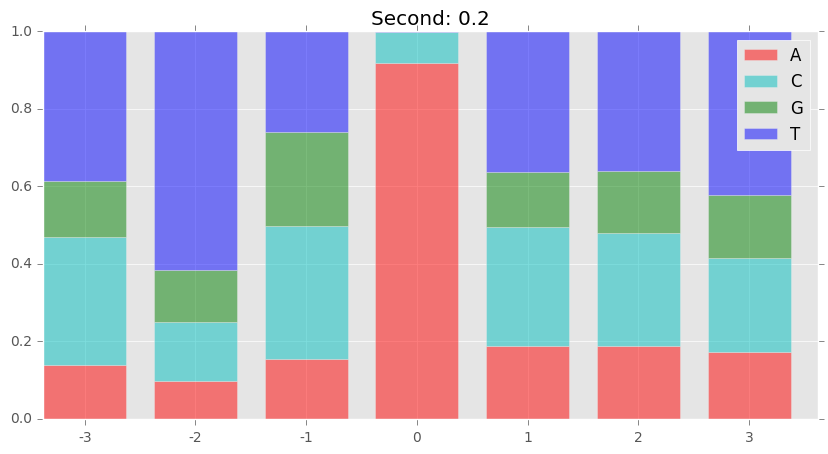

37276


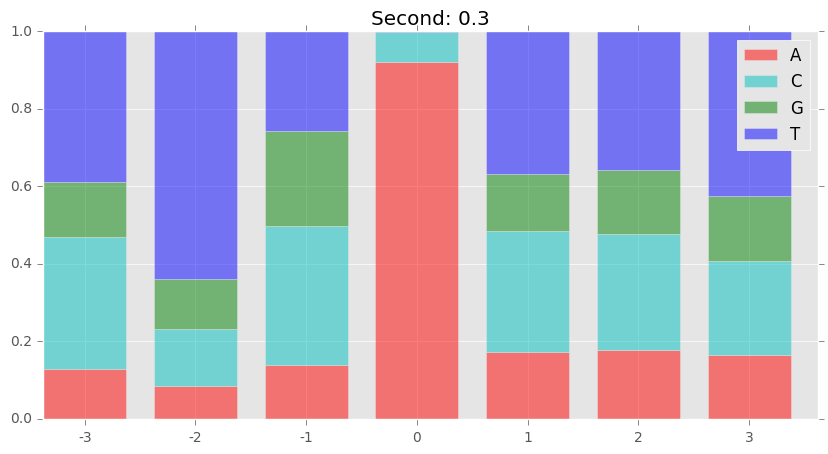

18056


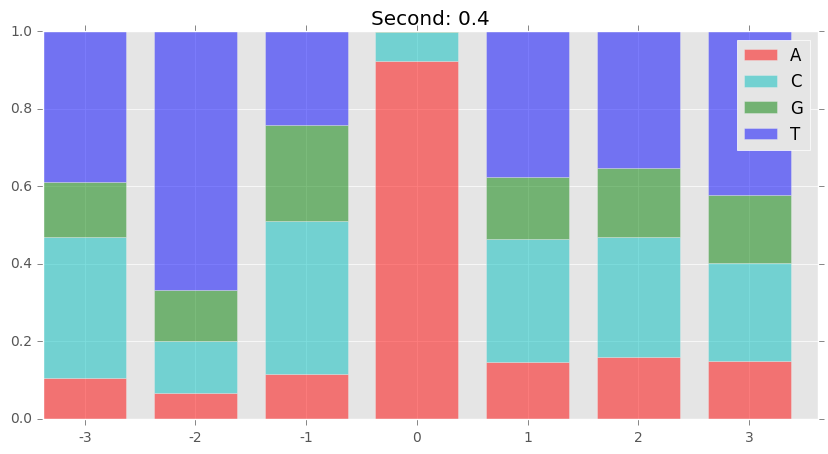

5811


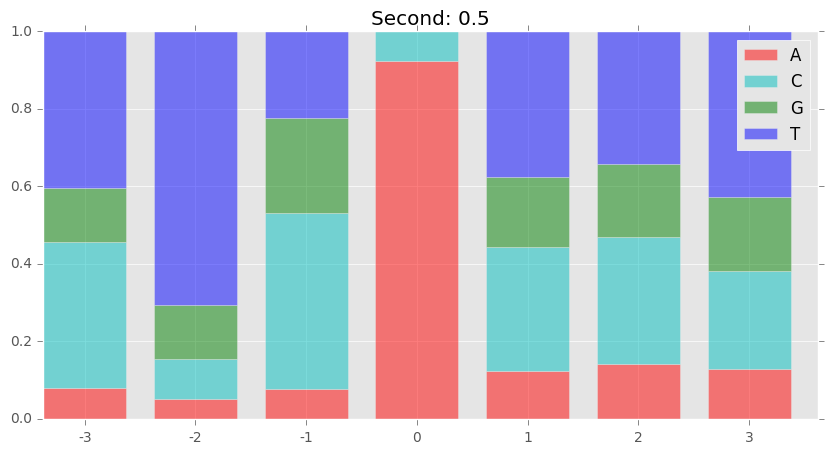

1114


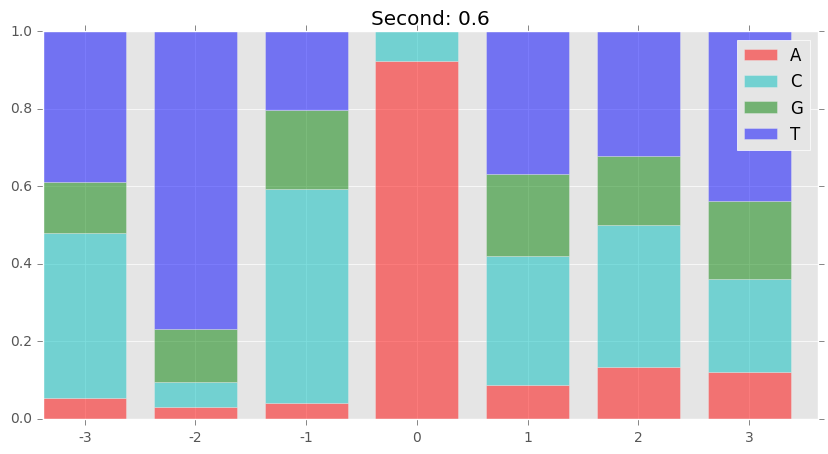

56


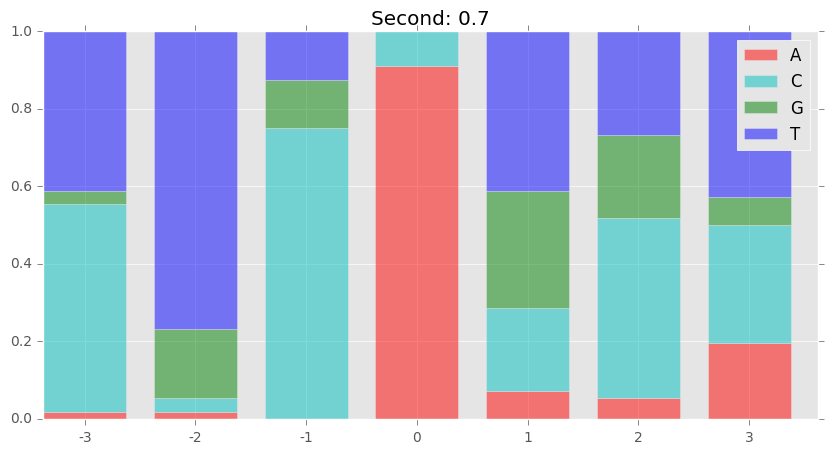

0


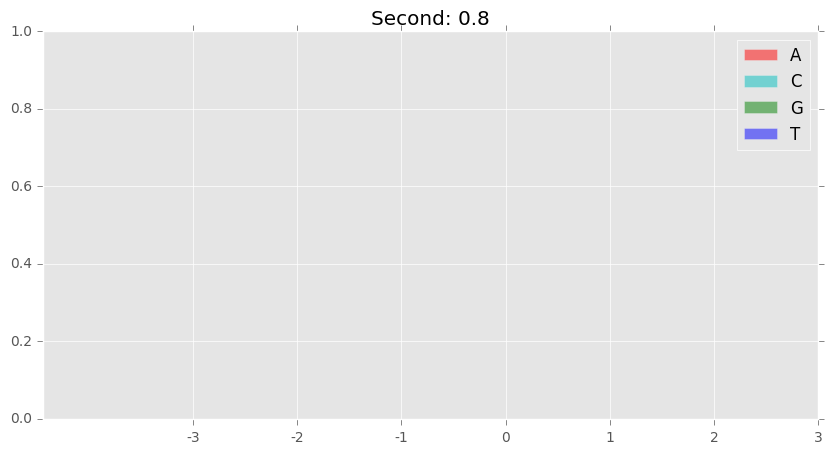

0


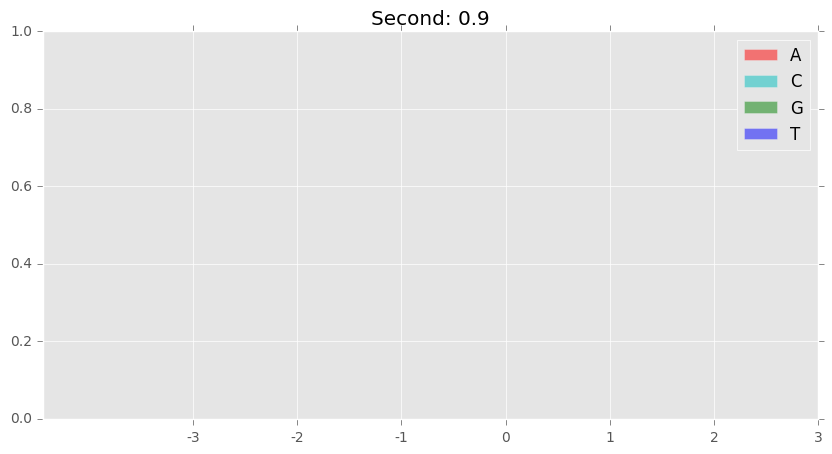

0


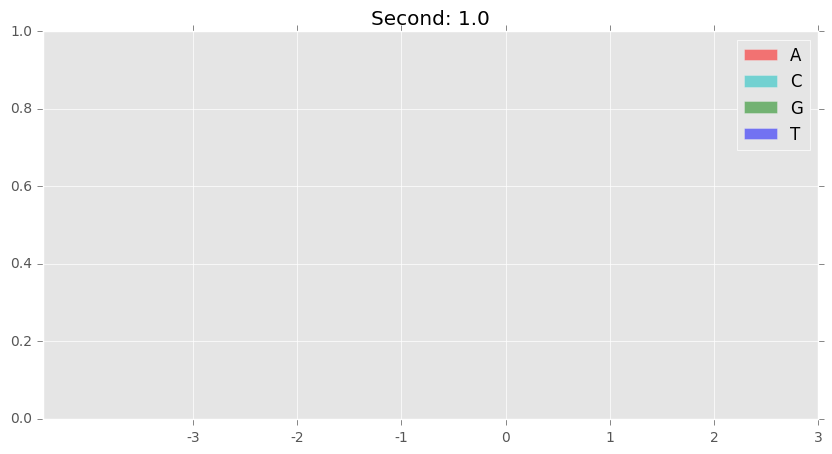

In [36]:
for thresh in np.linspace(0, 1, 11):
    K = 3
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_all, X_all):
        bp1 = np.argmax(target)
        bp2 = np.argmax(np.hstack([target[:bp1],
                                   np.zeros((1,)),
                                   target[bp1+1:]]))
        if abs(bp2-bp1) < 5: continue
        if target[bp2] < thresh: continue
        if 0 > bp2-K or bp2+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp2-K: bp2+K+1, :4]
        total += 1
    print total
    pwm_logo(counts / total, "Second: {}".format(thresh))

## Variants

In [20]:
from sklearn.utils import shuffle
import pandas
def read_variants(fn):
    return shuffle(pandas.read_csv(fn, delimiter = '\t'))

pathogenic = read_variants('../../variants/hg19.pathogenicv2.features.tsv')
#path_indel = read_variants('../../hg19.allpathogenic.features.tsv')
#benign = read_variants('../../hg19.benign.exons.tsv')

/Users/jpaggi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [21]:
# Make dict of chrom --> pos --> score
thresh = 1
i = 1
k_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, y_known):
    if chrom not in k_bps: k_bps[chrom] = {}
    for bp in np.nonzero(pred)[0]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        k_bps[chrom][idx] = strand

a_bps = {}
for chrom, pos, strand, target in zip(a_chroms, a_coords, a_strands, y_all* X_all[:, :, i]):
    if chrom not in a_bps: a_bps[chrom] = {}
    for bp in list(np.array(range(L))[target > thresh]) + [np.argmax(target)]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        a_bps[chrom][idx] = strand

n_bps = {}
for chrom, pos, strand, target in zip(n_chroms, n_coords,
                                    n_strands, y_novel* X_novel[:, :, i]):
    if chrom not in n_bps: n_bps[chrom] = {}
    for bp in list(np.array(range(L))[target > thresh]) + [np.argmax(target)]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        n_bps[chrom][idx] = strand
    
p_bps = {}
for chrom, pos, strand, target in zip(k_chroms, k_coords,
                                    k_strands, p_known* X_known[:, :, i]):
    if chrom not in p_bps: p_bps[chrom] = {}
    for bp in list(np.array(range(L))[target > thresh]) + [np.argmax(target)]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        p_bps[chrom][idx] = strand

In [22]:
# Make dict of chrom --> pos --> score
thresh = 1
k_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, y_known):
    if chrom not in k_bps: k_bps[chrom] = {}
    for bp in np.nonzero(pred)[0]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        k_bps[chrom][idx] = strand

a_bps = {}
for chrom, pos, strand, target in zip(a_chroms, a_coords, a_strands, y_all):
    if chrom not in a_bps: a_bps[chrom] = {}
    for bp in list(np.array(range(L))[target > thresh]) + [np.argmax(target)]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        a_bps[chrom][idx] = strand

n_bps = {}
for chrom, pos, strand, target in zip(n_chroms, n_coords,
                                    n_strands, y_novel):
    if chrom not in n_bps: n_bps[chrom] = {}
    for bp in list(np.array(range(L))[target > thresh]) + [np.argmax(target)]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        n_bps[chrom][idx] = strand
    
p_bps = {}
for chrom, pos, strand, target in zip(k_chroms, k_coords,
                                    k_strands, p_known):
    if chrom not in p_bps: p_bps[chrom] = {}
    for bp in list(np.array(range(L))[target > thresh]) + [np.argmax(target)]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        p_bps[chrom][idx] = strand

Mercer et. al. branch points
chr13:49047468:+:-1
chr10:50681659:-:-1
chr17:48273738:-:-1
chrX:107845097:+:0
chrX:153788599:+:0
chrX:153131293:-:0
chr10:50681659:-:0
chr16:8898599:+:0
chr2:242680425:+:0
chr21:47409500:+:0
chr11:118959325:+:0
chr13:49047470:+:1
chrX:107845097:+:1
chr13:49047470:+:1
chr13:49047470:+:1
chr2:225368567:-:1
chr15:80464485:+:1
chr10:99511131:+:2
chr16:8898599:+:2
Predictions in Mercer introns
chr13:49047468:+:-2
chr2:225368567:-:-2
chr13:49047470:+:0
chr13:49047470:+:0
chrX:153788599:+:0
chr21:47409627:+:0
chr13:49047470:+:0
chr16:8898599:+:0
chr2:242680425:+:0
chr11:118959790:+:0
chr2:225368565:-:0
chr21:47409500:+:0
chr11:118959325:+:0
chr11:118959791:+:1
chr11:118959791:+:1
chr10:99511131:+:2
Novel predicted branch points
chr17:73748508:+:-2
chr11:2187017:-:-2
chr1:156843392:+:-2
chr17:7124242:+:-2
chr5:127670562:-:-2
chr9:130578354:-:-2
chr17:73732344:+:-2
chr17:3552117:+:-2
chr9:137686903:+:-2
chr2:128180582:+:-2
chr11:2181258:-:-2
chr7:117282468:+:-1
chr

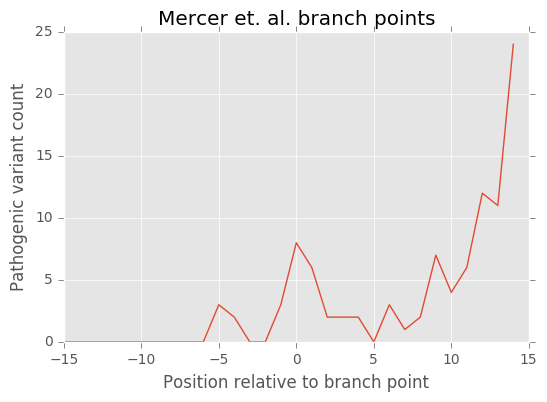

11


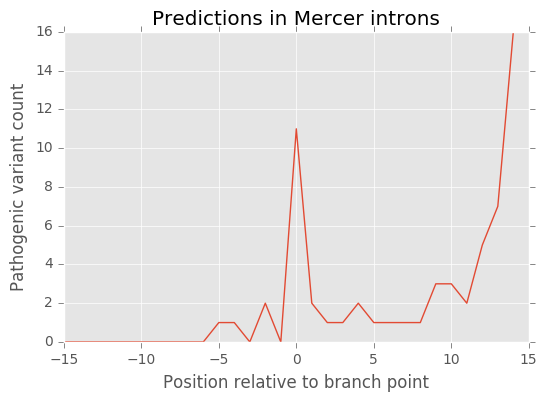

38


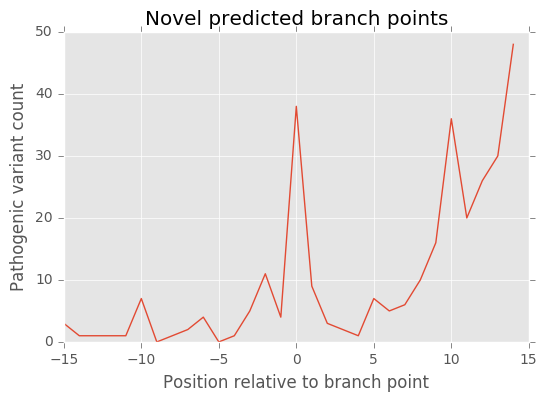

49


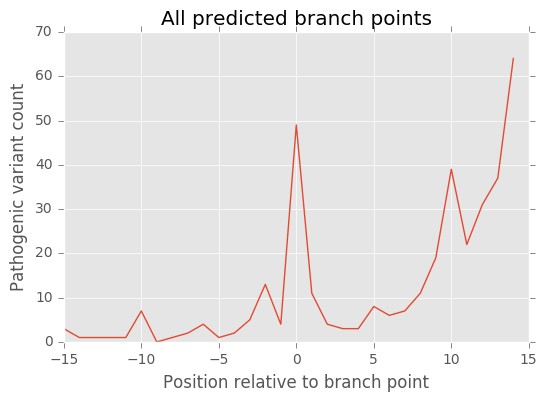

In [23]:
def var_enrichment(v, bps, report = []):
    hits = []
    for shift in range(-15, 15):
        hits += [0]
        for chrom, pos, strand in zip(v['CHROM'], v['POS'], v['strand']):
            s = -shift if strand == '+' else shift
            if pos+s in bps['chr'+str(chrom)]:
                hits[-1] += 1
                if shift in report:
                    print "chr{}:{}:{}:{}".format(chrom, pos,
                                                  strand, shift)
    return hits

names = ['Mercer et. al. branch points',
         'Predictions in Mercer introns',
         'Novel predicted branch points',
         'All predicted branch points']
bps = [k_bps, p_bps, n_bps, a_bps]

path = []
for bp, name in zip(bps, names):
    print name
    path += [var_enrichment(pathogenic, bp, range(-2, 3))]

for name, hits in zip(names, path):
    plt.plot(range(-15, 15), hits)
    print hits[15]
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("Pathogenic variant count")
    plt.show()

In [ ]:
exac = []
for bp in bps:
    exac += [var_enrichment(benign, bp, [])]

for name, hits in zip(names, exac):
    plt.plot(range(-15, 15), hits)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("ExAC variant count")
    plt.show()

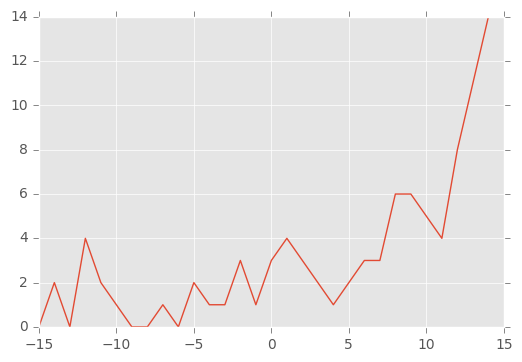

0.0


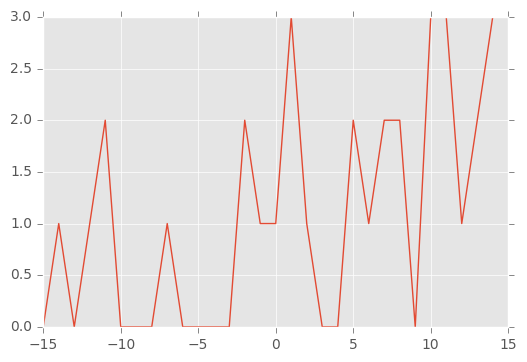

0.1


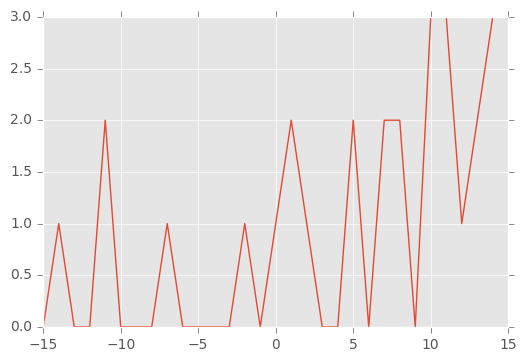

0.2


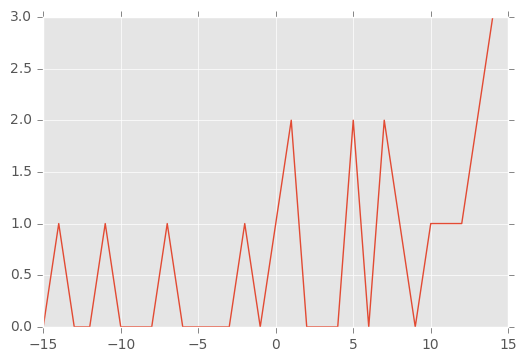

0.3


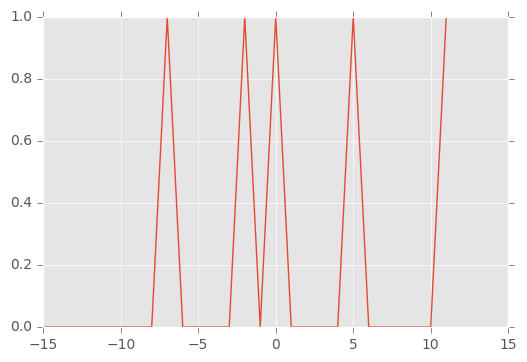

0.4


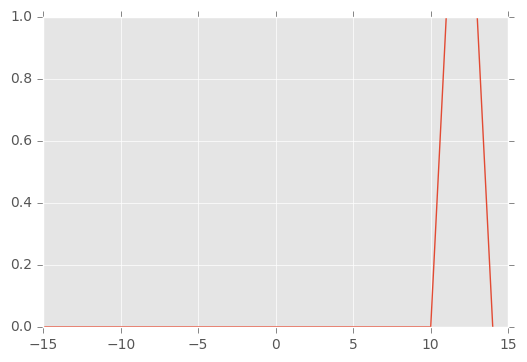

0.5


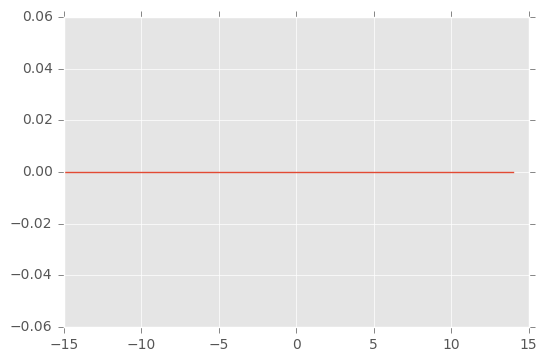

0.6


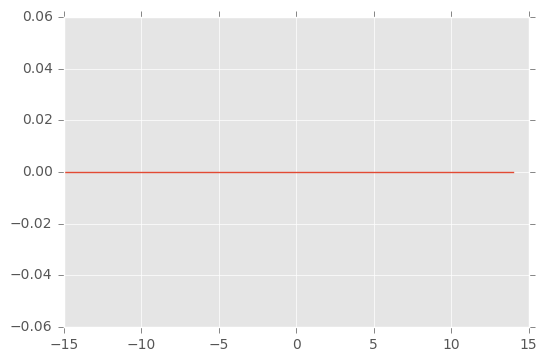

0.7


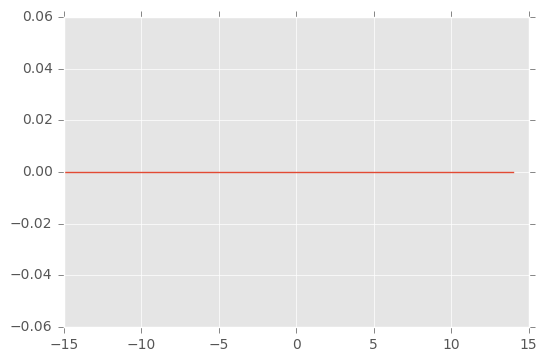

0.8


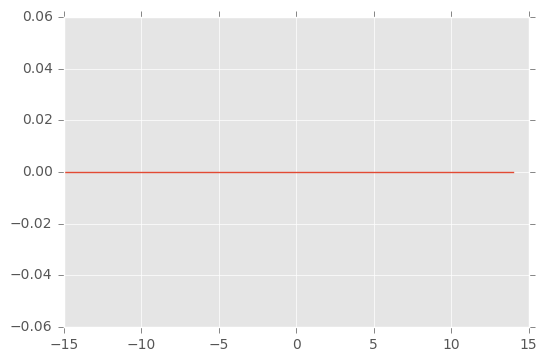

0.9


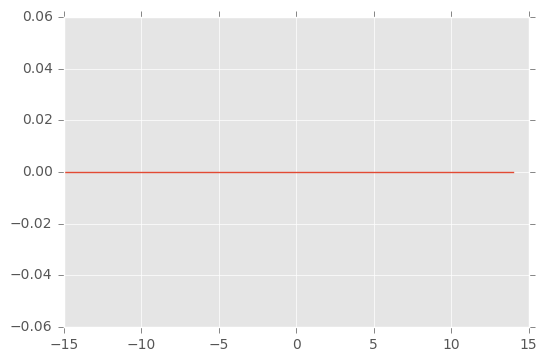

1.0


In [60]:
for thresh in np.linspace(0, 1, 11):
    a_bps = {}
    for chrom, pos, strand, target in zip(a_chroms, a_coords, a_strands, y_all):
        if chrom not in a_bps: a_bps[chrom] = {}
        bp1 = np.argmax(target)
        bp2 = np.argmax(np.hstack([target[:bp1], np.zeros((0,)), target[bp1+1:]]))
        if abs(bp1-bp2) < 5: continue
        if target[bp2] < thresh: continue
        idx = pos + (bp2-L+1 if strand == '+' else L-bp2)
        a_bps[chrom][idx] = strand
    hits = var_enrichment(pathogenic, a_bps, [])
    plt.plot(range(-15, 15), hits)
    plt.show()
    print thresh